### Exercises Week 3 

In [54]:
# %% imports
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# local imports
import Fast_MRI_dataloader
# import autoencoder_template
from matplotlib import pyplot as plt
from Fast_MRI_dataloader import create_dataloaders

# set-up folders
data_loc = os.getcwd()
print(data_loc)
data_loc = data_loc + '\Fast_MRI_Knee'
batch_size = 16
train_loader, val_loader = create_dataloaders(data_loc, batch_size)

C:\Users\20167271\Desktop\ML for signal processing\5LSL0-GIT\Assignment 4


## Exercise 5 - ConvNet
As a starting point for a deep learning solution, design an end-to-end convolutional neural
network. As input it should take an initial reconstruction from a partial k-space measurement
and output a guess for the final reconstruction. The net is not (yet) allowed to make
use of knowledge about the sampling mask.

(a) [1pt] What loss function would be most suitable to train this network, and what
underlying assumption have you made by choosing this loss function?

KL divergence is a metric to compare the distribution of pixel values between the input and output images. The MSE loss can be suitable as well but we already know that there is loss of spatial information given the mask and we do not want to penalize shifts or blurring, we want the network to reconstruct the original scan as similarly as possible with the input. Since the network does not know the mask, it should penalize the difference in distributions rather than shift in image. We assume the input distribution is symmetric.

(b) [3pt] Design a convolutional neural network of no more than 4 layers. Train it for at
least 10 epochs and plot both the training loss and testing

In [59]:
class KReconstruct(nn.Module):
    def __init__(self):
        super(KReconstruct, self).__init__()
        self.model = nn.Sequential(
            # 320x320
            nn.Conv2d(2, 4, kernel_size=12, stride=2, padding=0,dilation=1),  # 155x155
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.Conv2d(4, 16, kernel_size=7, stride=1, padding=0, dilation=2), # 143x143
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0, dilation=1), # 139x139
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=23, stride=2, padding=1, dilation=2, output_padding=1) # 320x320
        )

    def forward(self, x):
        xreal = torch.real(x)
        ximag = torch.imag(x)
        x = torch.cat((xreal, ximag), 1)
        
        img = self.model(x)
        out = nn.functional.log_softmax(img)
        return img, out


model = KReconstruct()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
#criterion = nn.KLDivLoss()
criterion = nn.MSELoss()


In [ ]:
# Begin training for 10 epochs

epochs=10
# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on: ', device)
model = model.to(device=device)
# keep track of losses
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []
loss_dict = {'train_loss':[], 'val_loss':[]}


print(f"\nTraining is about to start on {device}\n")
for e in range(epochs):
    print(f"\nTraining epoch {e}: \t")
    mia_loss = 0
    for batch_idx,(kspace, M, gt) in enumerate(tqdm(train_loader)):
        # prepare for training
        model.train(True)  
        optimizer.zero_grad()
        # move to gpu if available
        kspace = kspace.to(device=device)
        #M = M.to(device=device)
        gt = gt.to(device=device)
        # forward pass
        out,_ = model(kspace.unsqueeze(1))
        out = out.squeeze(1)
        # backpropagate loss
        loss = criterion(out, gt)
        loss = loss.to(torch.float16)
        loss.backward()
        mia_loss += loss.item()
        optimizer.step()
        
    # update loss dictionary
    loss_dict['train_loss'].append(mia_loss/(batch_idx+1))

    # print epoch loss
    print(f"\nEpoch training loss is {mia_loss/(batch_idx+1)}")

    with torch.no_grad():  # setting so that no backprop happens during validation
        model.eval()  # setting so that no backprop happens during validation
        vloss = 0
        for (kspace, M, gt) in tqdm(val_loader):
            kspace = kspace.to(device=device)
            #M = M.to(device=device)
            gt = gt.to(device=device)
            out,_ = model(kspace.unsqueeze(1))
            out = out.squeeze(1)
            vloss += criterion(out, gt).to(torch.float16).item()
        # update loss dictionary  
        loss_dict['val_loss'].append(vloss)
        # print validation loss
        print(f"\nEpoch validation loss is {vloss/len(val_loader)}")

# save trained model
model_path = os.getcwd() + '\Modelex5.pth'
torch.save(model.state_dict(), model_path)
    

  0%|          | 0/47 [00:00<?, ?it/s]

Running on:  cuda

Training is about to start on cuda


Training epoch 0: 	


C:\Users\20167271\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.4004893201462766


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.25843048095703125

Training epoch 1: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.24529120262632978


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.23444366455078125

Training epoch 2: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.22791825964095744


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.21816253662109375

Training epoch 3: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.2136256441156915


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.20562744140625

Training epoch 4: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.20074073304521275


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.19397735595703125

Training epoch 5: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.1892115816156915


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.1839141845703125

Training epoch 6: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.17880963264627658


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.17330169677734375

Training epoch 7: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.16933489860372342


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.16675567626953125

Training epoch 8: 	


 36%|███▌      | 17/47 [00:08<00:15,  2.00it/s]

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

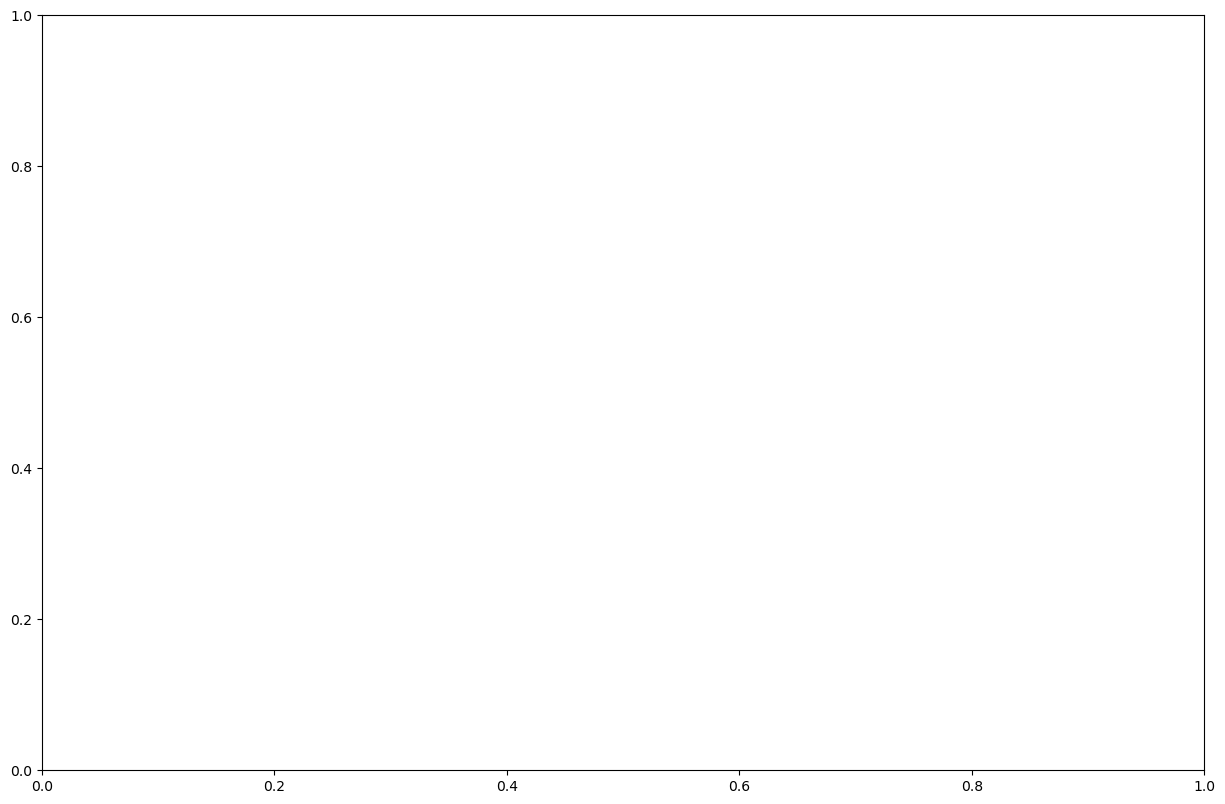

In [43]:
# Plot losses

#validation loss is actually test loss
plt.figure(figsize=(15,10),dpi=100)
plt.plot(range(epochs), loss_dic['train_loss'], 
         label='training loss', linewidth=5)
plt.plot(range(epochs), eval_dic['val_loss'], 
         label='test loss', linestyle='--', linewidth=5)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=0, prop={'size': 20})
